In [1]:
## Updated by gavento based on code by Sudarsh

from transformer_lens import HookedTransformer
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.neighbors import BallTree

# Load the pre-trained model
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


model = HookedTransformer.from_pretrained("Qwen/Qwen2-0.5B", device=device)
# gemma_model = HookedTransformer.from_pretrained("gemma-2b", device="mps")
torch.set_printoptions(threshold=1_000_000)
torch.set_printoptions(linewidth=1_000_000)

/usr/local/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loaded pretrained model Qwen/Qwen2-0.5B into HookedTransformer


In [2]:
# from pynndescent import NNDescent

# W_E = model.embed._parameters["W_E"].detach().cpu()
# index = NNDescent(W_E)
# index.prepare()

import faiss

resources = faiss.StandardGpuResources()
index = faiss.IndexFlatL2(model.embed._parameters["W_E"].shape[1])
index = faiss.index_cpu_to_gpu(resources, 0, index)

W_E = model.embed._parameters["W_E"].detach()

index.add(model.embed._parameters["W_E"].detach().cpu().numpy())

In [3]:
# Define the input text
input_text = 'Consensus is lacking among historians with regard to what the actual events surrounding this event. The portrayal of Ahuntisc and Viel as martyrs in popular culture is objected to by those researchers who reject the notion that they were murdered. The ethnic identity and the actual phonetic name of the missionary referred to as Ahuntsic are also not universally agreed upon by authors.'

# Tokenize the input text
tokens = model.to_tokens(input_text)[:, 1:] # Skip BOS
print(tokens.shape, tokens)
print(model.tokenizer.convert_ids_to_tokens(tokens[0]))

# 
# embeddings_tree = BallTree(W_E.numpy(), leaf_size=1)

SOFT_TOKENS = 50
MODEL_DIM = 896
L2REG = 0.5

def exec_model(model, first_tokens_embedding, tokens):
    residual, _tks, _spe, _attn = model.input_to_embed(tokens)

    skip = first_tokens_embedding.shape[1]
    both = torch.concat([first_tokens_embedding, residual], axis=1)
    #print(first_tokens_embedding.shape, residual.shape, both.shape)
    return model(both, start_at_layer=0)

def predict(model, first_tokens_embedding, num_tokens):
    tokens = []
    skip = first_tokens_embedding.shape[1]
    for i in range(num_tokens):
        toks = torch.tensor(tokens, dtype=torch.long)
        residual, _tks, _spe, _attn = model.input_to_embed(toks)
        both = torch.concat([first_tokens_embedding.detach(), residual], axis=1)
        res = model(both, start_at_layer=0)[0]
        next_token = torch.argmax(res, axis=-1)[-1].item()  # Get the last token predicted
        tokens.append(next_token)
        probs = torch.softmax(res, axis=-1)
        #print(model.tokenizer.convert_ids_to_tokens(tokens))
        #print(residual.shape, toks.shape, both.shape, res.shape, probs.shape)
    
    return (model.tokenizer.decode(tokens),
            model.tokenizer.convert_ids_to_tokens(tokens),
            torch.tensor(tokens).cpu())  # Convert the final token list to a tensor

def token_alignment_loss(logits, tokens, first_tokens_embedding, alpha=1.0, beta=0.7, kappa=0.1, gamma=0.1):
    # Calculate the cross-entropy loss
    def l2(x): return torch.sum(x ** 2) ** 0.5

    logits = logits[SOFT_TOKENS - 1:-1, :]


    ce_loss = F.cross_entropy(logits, tokens)
    
    # Calculate the token matching loss
    pred_tokens = torch.argmax(logits, dim=-1)
    match_loss = (pred_tokens != tokens).float().mean()
    
    # L2 regularization
    l2_loss = l2(first_tokens_embedding)

    nn_loss = nearest_neighbour_loss(first_tokens_embedding[0], index, W_E, device=device)

    # Combine the losses
    total_loss = alpha * match_loss + beta * ce_loss + gamma * l2_loss + kappa * nn_loss

    return total_loss
# 
def nearest_neighbour_loss(x, index, W_E, device):
    # x should be of shape (N, 896)
    
    # Convert the input tensor to numpy and ensure it's on the CPU
    x_np = x.detach().cpu().squeeze(0).numpy().astype('float32')
    
    # Perform the nearest neighbor search using the Faiss index
    # Note: Faiss requires the data to be in float32 format
    distances, indices = index.search(x_np, k=3)
    
    # Get the first nearest neighbor index
    ind = indices[:, 0].flatten()
    
    # Fetch the nearest neighbor embeddings from W_E
    nearest_neighbour = W_E[ind]
    
    # Calculate the L2 distance between x and its nearest neighbors
    distance = torch.norm(x - nearest_neighbour, p=2, dim=1)
    
    # Return the sum of the distances
    return torch.sum(distance)



torch.Size([1, 74]) tensor([[15220, 13626,   374, 31061,  4221, 50701,   448,  5250,   311,  1128,   279,  5042,  4357, 14590,   419,  1538,    13,   576, 73933,   315, 16366,  3850,  3427,   323, 11401,   301,   438, 59349,  5428,   304,  5411,  7674,   374, 75779,   311,   553,  1846, 11811,   879,  7850,   279, 22240,   429,   807,  1033, 31385,    13,   576, 21551,  9569,   323,   279,  5042, 50823,  5298,   829,   315,   279, 72898, 13862,   311,   438, 16366, 36940,   292,   525,  1083,   537, 60428,  7230,  5193,   553, 12014,    13]], device='cuda:0')
['Cons', 'ensus', 'Ġis', 'Ġlacking', 'Ġamong', 'Ġhistorians', 'Ġwith', 'Ġregard', 'Ġto', 'Ġwhat', 'Ġthe', 'Ġactual', 'Ġevents', 'Ġsurrounding', 'Ġthis', 'Ġevent', '.', 'ĠThe', 'Ġportrayal', 'Ġof', 'ĠAh', 'unt', 'isc', 'Ġand', 'ĠVi', 'el', 'Ġas', 'Ġmarty', 'rs', 'Ġin', 'Ġpopular', 'Ġculture', 'Ġis', 'Ġobjected', 'Ġto', 'Ġby', 'Ġthose', 'Ġresearchers', 'Ġwho', 'Ġreject', 'Ġthe', 'Ġnotion', 'Ġthat', 'Ġthey', 'Ġwere', 'Ġmurdered', '.'

0

Step 0, nnloss=4111.42236328125, Maximum Correct=0, Correct=0, Loss=774.84033203125/0, L2=138.3819580078125, LR=[0.9989408977717675], Pred=' is a very good way to get a good idea of what the author is trying to say. It'
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50

Step 50, nnloss=1375.131591796875, Maximum Correct=1, Correct=1, Loss=214.8732452392578/1, L2=48.134788513183594, LR=[0.9473915220904213], Pred=' Sim based according with with with with with with with with with with with with with with with with with'
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Step 100, nnloss=1900.218994140625, Maximum Correct=1, Correct=0, Loss=330.33258056640625/1, L2=67.19544982910156, LR=[0.8985023019188398], Pred='                     '
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
11

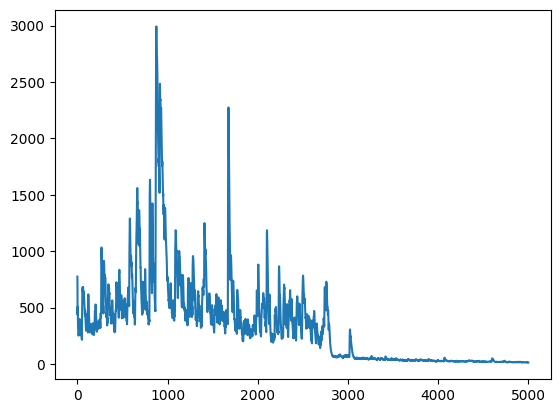

In [13]:
import math

first_tokens_embedding = torch.randn(size=(1, SOFT_TOKENS, MODEL_DIM), dtype=torch.float32, device=device)
if device == "cuda": 
    first_tokens_embedding = first_tokens_embedding.cuda()
if device == "mps":
    first_tokens_embedding = first_tokens_embedding.to(torch.float32).to(device)

first_tokens_embedding = first_tokens_embedding.requires_grad_(True)

num_steps = 5000  # Number of optimization steps
# Define the optimizer for the first tokens' embedding
optimizer = torch.optim.Adam([first_tokens_embedding], lr=0.02 * SOFT_TOKENS)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)

loss_arr = []

def l2(x): return torch.sum(x ** 2) ** 0.5

last_corr = 0
max_corr = 0
lossahead = 5 + SOFT_TOKENS * 2
lookahead = 20
kappa = 0.0
alpha = 0.0
beta = 1.0
for step in range(num_steps + 1):
    # Zero the gradients
    optimizer.zero_grad()

    # Replace the first token's embedding in the reg_embeddings tensor
    logits = exec_model(model, first_tokens_embedding, tokens)
    #print(logits.shape)
    # Calculate the loss
    # loss = F.cross_entropy(logits.flatten(0, 1)[:last_corr+lossahead], tokens.flatten(0, 1)[:last_corr+lossahead]) + L2REG * l2(first_tokens_embedding)

    flattened_logits = logits.flatten(0, 1)[:last_corr+lookahead+SOFT_TOKENS]
    flattened_tokens = tokens.flatten(0, 1)[:last_corr+lookahead]

    loss = token_alignment_loss(flattened_logits, flattened_tokens, first_tokens_embedding, alpha=0.0, beta=1.0, kappa=kappa)
    
    # Backpropagate the loss with retain_graph=True
    loss.backward()

    # Optimize the first token's embedding
    optimizer.step()
    lr_scheduler.step()

    loss_arr.append(loss.item())

    # Print the loss for every 100 steps
    print(step)
    if step % 50 == 0:
        if last_corr > 30:
            kappa = 2.0

        with torch.no_grad():  # Disable gradient computation for prediction

            ps = predict(model, first_tokens_embedding, last_corr+lookahead)
            temp_corr = (ps[2][:min(last_corr+lookahead, tokens.shape[1])] == tokens[:, :last_corr+lookahead].cpu()).sum()
            max_corr = max(temp_corr, max_corr)
            if temp_corr > last_corr:
                last_corr += math.ceil((temp_corr - last_corr) / 4)
            print(f"\nStep {step}, nnloss={nearest_neighbour_loss(first_tokens_embedding, index, W_E, device=device)}, Maximum Correct={max_corr}, Correct={temp_corr}, Loss={loss.item()}/{last_corr}, L2={l2(first_tokens_embedding).detach().cpu()}, LR={lr_scheduler.get_last_lr()}, Pred={ps[0]!r}")
    

    # just comment out this part if you want to not add tokens
    # if step % 20 == 0 and step != 0:
    #     new_tokens_embedding = torch.tensor(np.random.normal(0.0, 768**(-0.5), size=(1, 1, MODEL_DIM)), dtype=torch.float32, requires_grad=True).to(device)
    #     print("ADDING NEW TOK")
    #     first_tokens_embedding = torch.cat([ new_tokens_embedding, first_tokens_embedding], dim=1)
    #     first_tokens_embedding = first_tokens_embedding.detach().requires_grad_(True)

    #     # Reinitialize the optimizer with the updated embedding
    #     optimizer = torch.optim.Adam([first_tokens_embedding], lr=0.02, amsgrad=True)
    #     lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)


plt.plot(loss_arr)

In [12]:
new_token_embeddings = torch.rand(size=first_tokens_embedding.shape, dtype=torch.float32, device=device)

"""def nearest_neighbour_loss(x, index, W_E, device):
    # x should be of shape (N, 896)
    
    # Convert the input tensor to numpy and ensure it's on the CPU
    x_np = x.detach().cpu().squeeze(0).numpy().astype('float32')
    
    # Perform the nearest neighbor search using the Faiss index
    # Note: Faiss requires the data to be in float32 format
    distances, indices = index.search(x_np, k=3)
    
    # Get the first nearest neighbor index
    ind = indices[:, 0].flatten()
    
    # Fetch the nearest neighbor embeddings from W_E
    nearest_neighbour = W_E[ind]
    
    # Calculate the L2 distance between x and its nearest neighbors
    distance = torch.norm(x - nearest_neighbour, p=2, dim=1)
    
    # Return the sum of the distances
    return torch.sum(distance)""" 

x_np = first_tokens_embedding[0].detach().cpu().squeeze(0).numpy().astype('float32')
distances, indices = index.search(x_np, k=3)
ind = indices[:, 0].flatten()         
# concatenate W_E[ind]
nearest_neighbour = W_E[ind].unsqueeze(0)
print(nearest_neighbour.shape)

# get distance between first_token_embeddings and nearest_neighbour
distance = torch.norm(first_tokens_embedding - nearest_neighbour, p=2, dim=2)
print(distance)



torch.Size([1, 50, 896])
tensor([[0.0055, 0.0076, 0.0072, 0.0094, 0.0045, 0.0092, 0.0123, 0.0093, 0.0105, 0.0082, 0.0097, 0.0115, 0.0146, 0.0079, 0.0195, 0.0093, 0.1252, 0.0061, 0.0083, 0.0082, 0.0089, 0.0079, 0.0088, 0.0094, 0.0068, 0.0112, 0.0085, 0.0065, 0.0079, 0.0080, 0.0093, 0.0199, 0.0088, 0.0085, 0.0076, 0.0075, 0.0081, 0.0070, 0.0091, 0.0231, 0.0093, 0.0164, 0.0356, 0.0506, 0.3930, 0.0116, 0.0426, 0.1727, 0.0277, 0.0211]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [9]:
# The prediction runs only given the following tensor shaped (1,1,768):
# print(first_tokens_embedding)
MAGIC = nearest_neighbour
# Compare the following:
print(repr(predict(model, MAGIC, 90)[0]))
print(repr(input_text))

'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'
'Consensus is lacking among historians with regard to what the actual events surrounding this event. The portrayal of Ahuntisc and Viel as martyrs in popular culture is objected to by those researchers who reject the notion that they were murdered. The ethnic identity and the actual phonetic name of the missionary referred to as Ahuntsic are also not universally agreed upon by authors.'
